# RAMP CLASSIFICATION
For my Master thesis I made thousands of models with the purpose of forecasting PV system power output 64 timesteps of 15 minutes ahead as well as 32 timesteps of 1 minute ahead. During that research the idea that a model dedicated to the task of ramp detection might outperform a regression model for that specific task. This ipython notebook contains a mockup example of how one could go about classifying the next 32 timesteps as either a ramp event or not ramp event. This one model can correctly classify the following 32 timesteps as either a ramp or no ramp 79% of the time without any further optimization. Many assumptions, and possibly even errors might reside in this document, it was compiled to serve as inspiration on how this task COULD be done as a classification task rather than how it SHOULD be done.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import ramp_score as rs #downloaded from: https://github.com/nii3lsh/Ramp-score/blob/master/ramp_score.py

# Loading the dataset 
note: this dataset could not be made publicly available. 

In [2]:
df = pd.read_csv('../pv_data/ML_input_1T.csv', 
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format = True)
print(df.shape)
print('this dataframe has ', df.shape[0], ' measurements for the years 2015 - 2017 and ', df.shape[1], ' features, the first feature is historical PV power output')

(1578240, 51)
this dataframe has  1578240  measurements for the years 2015 - 2017 and  51  features, the first feature is historical PV power output


# Scaling the dataset between values of 0 and 1
This is done twice, once for the features as a collection, and once for the dependent variable. This way the option to return the output of the model to the scale of the dataset is available.

In [3]:
cols = df.columns
index = df.index
df = df.values
scaler_target = MinMaxScaler()
target = scaler_target.fit_transform(df[:,:1])
scaler_features = MinMaxScaler()
features = scaler_features.fit_transform(df[:,1:])
df = np.concatenate((target, features), axis=1)
df = pd.DataFrame(df, index = index, columns = cols)

# Removing excessive 0's in the dataset
TRAIN_TEST_SPLIT defines the last timestep to be used for training, all timesteps after this point are only used for validation purposes. This is done to combat over-fitting.

In [4]:
sun_up, sun_down = '06:00:00', '17:45:00'
df = df.between_time(sun_up, sun_down)
TRAIN_TEST_SPLIT = len(df.loc['1-1-2015':'31-12-2016'])

# Making functions

### Sliding window function to cut the dataset into model input and labels

In [5]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index, step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

## Function to remove any samples that contain a single missing value in either the input or the label

In [6]:
def remove_nan(X,Y):
    x = []
    y = []
    for sample in range(X.shape[0]):
        if np.isnan(X[sample,:,:]).any() | np.isnan(Y[sample,:]).any():
            None
        else:
            x.append(X[sample,:,:])
            y.append(Y[sample,:])
    x = np.array(x)
    y = np.array(y)
    return x, y

## Convert label values into binary, 1 = ramp event, 0 = no ramp event
The ramp score was calculated for the 32 timestep label generated by the previous function. The ramp_score_value determines the minimum ramp score of a 32 timestep label that constitutes a ramp event. The avg_mins variable determines the size of the sliding window used to calculate the ramp score.

In [7]:
def make_ramp_scores(y_train, avg_mins, ramp_score_value):
    ramp_scores = []
    for i in range(y_train.shape[0]):
        ramps = rs.get_ramp_score(np.repeat(y_train[i,:].mean(),32), 
                                            y_train[i,:], 
                                            avg_mins = avg_mins, 
                                            plot=False)
        if ramps >= ramp_score_value:
            ramps = 1
        else:
            ramps = 0
        ramp_scores.append(ramps)
    return np.array(ramp_scores, ndmin=2).T

## Convenience function to wrap the above functions into a single convenient wrapper

In [8]:
def make_train_test(data, target, train_test_split, history_size, target_size, step, avg_mins, ramp_score_value):
    x_tr, y_tr = multivariate_data(data, target, 0, train_test_split, history_size, target_size, step)
    x_tr, y_tr = remove_nan(x_tr, y_tr)
    x_te, y_te = multivariate_data(data, target, train_test_split, None, history_size, target_size, step)
    x_te, y_te = remove_nan(x_te, y_te)
    y_tr = make_ramp_scores(y_tr, avg_mins, ramp_score_value)
    y_te = make_ramp_scores(y_te, avg_mins, ramp_score_value)
    return x_tr, y_tr, x_te, y_te

## LSTM model used in this notebook
This is by no means an optimal model configuration. Binary crossentropy is the loss function used to determine the difference between the model's output and the label and is subsequently use the "Adam" optimizer to perform gradient descent.

In [9]:
def make_model(x_train, y_train):
    model = Sequential()
    model.add(Input(shape = (x_train.shape[1], x_train.shape[2])))
    
    model.add(LSTM(50))
    model.add(Dense(units            = 20, 
                    activation       = 'relu'))
    model.add(Dropout(rate           = 0.5))
    model.add(Dense(units            = y_train.shape[1]))
    model.add(Activation('sigmoid'))
    
    model.compile(loss               = 'binary_crossentropy', 
                  optimizer          = 'adam',
                  metrics            = ['accuracy'])
    return model

# Using above functions to create model input and labels 
For both the training and validation datasets.

In [10]:
data = df.values

ramp_score_value = 0.02
ramp_score_average_minutes = 5
x_train, y_train, x_test, y_test = make_train_test(data, data[:,0],
                                                   TRAIN_TEST_SPLIT,
                                                   180,
                                                   32,
                                                   32,
                                                   ramp_score_average_minutes,
                                                   ramp_score_value)

# Defining the model and creating a summary of the model's content

In [11]:
model = make_model(x_train, y_train)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                20400     
_________________________________________________________________
dense (Dense)                (None, 20)                1020      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0
_________________________________________________________________


# Training the model
"loss" refers to the value of the loss function on the training set, "val_loss" refers to the value of te loss function on the testing set. When "val_loss" start to go up, the model has begun overfitting on the input data. 

Train on 6136 samples, validate on 4282 samples
Epoch 1/15
6136/6136 [==============================] - 4s 717us/sample - loss: 0.5232 - accuracy: 0.7179 - val_loss: 0.5297 - val_accuracy: 0.7338
Epoch 2/15
6136/6136 [==============================] - 2s 261us/sample - loss: 0.4794 - accuracy: 0.7591 - val_loss: 0.5332 - val_accuracy: 0.7333
Epoch 3/15
6136/6136 [==============================] - 2s 257us/sample - loss: 0.4495 - accuracy: 0.7674 - val_loss: 0.5082 - val_accuracy: 0.7377
Epoch 4/15
6136/6136 [==============================] - 2s 258us/sample - loss: 0.4205 - accuracy: 0.7999 - val_loss: 0.5235 - val_accuracy: 0.7574
Epoch 5/15
6136/6136 [==============================] - 2s 259us/sample - loss: 0.4202 - accuracy: 0.8113 - val_loss: 0.5123 - val_accuracy: 0.7791
Epoch 6/15
6136/6136 [==============================] - 2s 258us/sample - loss: 0.4244 - accuracy: 0.7958 - val_loss: 0.4936 - val_accuracy: 0.7457
Epoch 7/15
6136/6136 [==============================] - 2s 260us

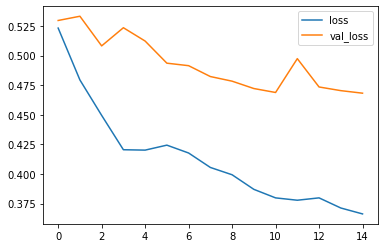

In [12]:
history = model.fit(x_train, y_train, 
                    epochs          = 15, 
                    batch_size      = 48, 
                    validation_data = (x_test, y_test))

plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

# Converting the model's output into binary
Ramp / no ramp, the top plot shows the model's confidence that any specific 32 timestep period will have a ramp score above the value attributed to "ramp_score_value". The bottom plot shows conversion into binary, "cutoff" defines the value above which the model's output is converted into a 1, and below which the model's output is converted into 0. Where 1 means the model thinks a ramp event is coming up, and 0 means no ramp event is coming up. The F1 classification error score as well as the accuracy score are calculated and shown.

f1 score:  0.76274694261524
accuracy score:  0.7055114432508174


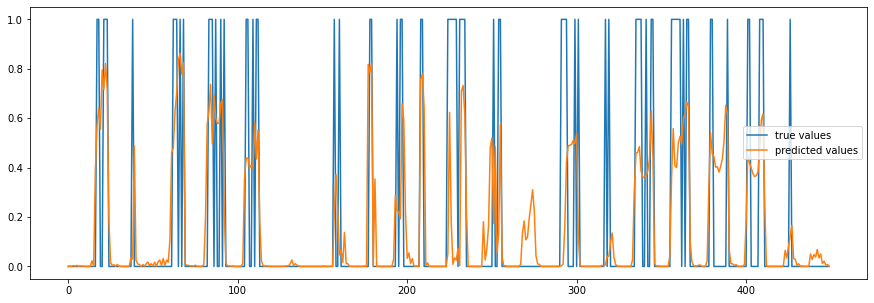

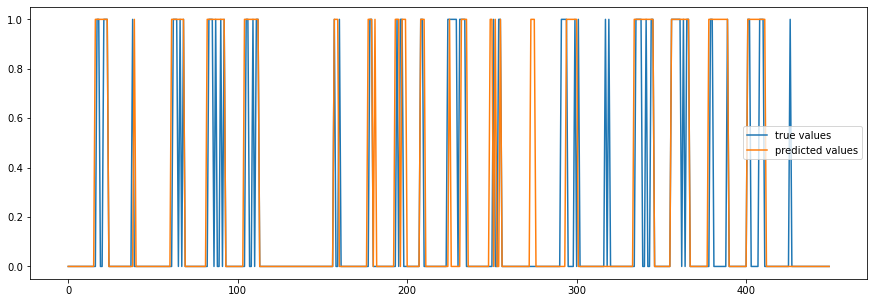

In [13]:
predictions = model.predict(x_test)

plt.figure(figsize=(15,5))
plt.plot(y_test[:450], label = 'true values')
plt.plot(predictions[:450], label = 'predicted values')
plt.legend()

cutoff = 0.2
predictions_binary = predictions.copy()
predictions_binary[predictions_binary > cutoff] = 1
predictions_binary[predictions_binary <= cutoff] = 0

f1 = f1_score(y_test, predictions_binary)
acc_score = accuracy_score(y_test, predictions_binary)
print('f1 score: ', f1)
print('accuracy score: ', acc_score)

plt.figure(figsize=(15,5))
plt.plot(y_test[:450], label = 'true values')
plt.plot(predictions_binary[:450], label = 'predicted values')
plt.legend()

# Finding the optimal value for the cutoff value
By trying 41 different values in a range between 0.1 and 0.5.
Note: This value is different for every trained model.
Note: This method is but a guess at the right approach, please take this with a grain of salt, it is merely shown to serve as inspiration for future, more rigorous analysis.

with a cutoff value of  40  the F1 score and accuracy score of this ramp classification problem is  0.78


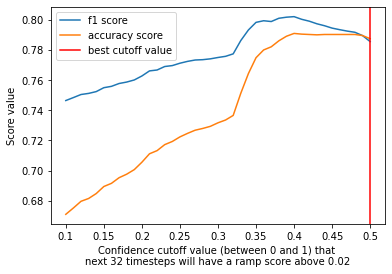

In [28]:
f1s = []
accs = []

for i in range(10, 51, 1):
    cutoff = i/100
    predictions_binary = predictions.copy()
    predictions_binary[predictions_binary > cutoff] = 1
    predictions_binary[predictions_binary <= cutoff] = 0
    f1 = f1_score(y_test, predictions_binary)
    acc_score = accuracy_score(y_test, predictions_binary)
    f1s.append(f1)
    accs.append(acc_score)
    
    
optimal_value = np.array(f1s) - np.array(accs)
value = optimal_value.min()
value = np.where(optimal_value == value)

x = np.arange(10, 51, 5) / 100
xi = range(0, 41, 5)
 

plt.figure()
plt.plot(f1s, label = 'f1 score')
plt.plot(accs, label = 'accuracy score')
plt.axvline(value[0], c='r', label = 'best cutoff value')
plt.xticks(xi,x) 
plt.xlabel('Confidence cutoff value (between 0 and 1) that \nnext 32 timesteps will have a ramp score above ' + str(ramp_score_value))
plt.ylabel('Score value')
plt.legend()

print('with a cutoff value of ', str(int(value[0])), ' the F1 score and accuracy score of this ramp classification problem is ', round(f1s[20], 2))